## In this notebook we discuss the 3 most important ways to decrease the size of a model while retaining most of the model's intelligence.

- > 1- Pruning
- > 2- Quantization
- > 3- Distillation

In [1]:
!pip install tensorflow_model_optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 7.1 MB/s eta 0:00:00


In [2]:
!pip uninstall keras

Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/keras-3.8.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-3.8.0


In [3]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import os
import matplotlib.pyplot as plt
import time
import numpy as np

In [4]:
# Use tf.keras instead of tensorflow.keras
datasets = tf.keras.datasets
layers = tf.keras.layers
models = tf.keras.models
applications = tf.keras.applications

In [5]:
# Load CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [6]:
# Create a tf.data.Dataset pipeline with resizing
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize on-the-fly
    image = image / 255.0  # Normalize
    return image, label

batch_size = 32

# Create datasets with batching and preprocessing
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [7]:
# Load ResNet50 model
base_model = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
# Freeze the base model and add custom classification head
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [9]:
# Compile and train top layers
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=10, validation_data=test_dataset) # 33 min

Epoch 1/10
1563/1563 [==============================] - 191s 118ms/step - loss: 2.2389 - accuracy: 0.1580 - val_loss: 2.1654 - val_accuracy: 0.1751
Epoch 2/10
1563/1563 [==============================] - 199s 127ms/step - loss: 2.0540 - accuracy: 0.2333 - val_loss: 2.0322 - val_accuracy: 0.2421
Epoch 3/10
1563/1563 [==============================] - 198s 127ms/step - loss: 1.9861 - accuracy: 0.2559 - val_loss: 1.9868 - val_accuracy: 0.2612
Epoch 4/10
1563/1563 [==============================] - 188s 120ms/step - loss: 1.9440 - accuracy: 0.2750 - val_loss: 1.9532 - val_accuracy: 0.2780
Epoch 5/10
1563/1563 [==============================] - 188s 120ms/step - loss: 1.9094 - accuracy: 0.2901 - val_loss: 1.9170 - val_accuracy: 0.2989
Epoch 6/10
1563/1563 [==============================] - 188s 120ms/step - loss: 1.8845 - accuracy: 0.3042 - val_loss: 1.8714 - val_accuracy: 0.3192
Epoch 7/10
1563/1563 [==============================] - 198s 127ms/step - loss: 1.8565 - accuracy: 0.3183 - val_

In [10]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False  # Freeze first 100 layers

In [11]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [12]:
# Fine tune model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=3, validation_data=test_dataset) # 17 min

Epoch 1/3
1563/1563 [==============================] - 333s 204ms/step - loss: 1.8851 - accuracy: 0.3658 - val_loss: 1.9291 - val_accuracy: 0.3725
Epoch 2/3
1563/1563 [==============================] - 328s 210ms/step - loss: 1.4682 - accuracy: 0.4870 - val_loss: 2.1790 - val_accuracy: 0.3486
Epoch 3/3
1563/1563 [==============================] - 317s 203ms/step - loss: 1.3120 - accuracy: 0.5394 - val_loss: 3.0735 - val_accuracy: 0.2939


### Pruning

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# Apply pruning to the trained model
pruning_params = { 'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
     initial_sparsity=0.30, final_sparsity=0.70, begin_step=0, end_step=len(train_images)//32 * 5) }
model_pruned = prune_low_magnitude(model, **pruning_params)
model_pruned.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_pruned.fit(train_dataset, epochs=5, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])
# Strip pruning
model_pruned = tfmot.sparsity.keras.strip_pruning(model_pruned) # 30 min

Epoch 1/5
1563/1563 [==============================] - 410s 221ms/step - loss: 2.4941 - accuracy: 0.1007
Epoch 2/5
1563/1563 [==============================] - 340s 217ms/step - loss: 2.3028 - accuracy: 0.0972
Epoch 3/5
1563/1563 [==============================] - 338s 216ms/step - loss: 2.3028 - accuracy: 0.0963
Epoch 4/5
1563/1563 [==============================] - 338s 216ms/step - loss: 2.3029 - accuracy: 0.0959
Epoch 5/5
1563/1563 [==============================] - 339s 217ms/step - loss: 2.3028 - accuracy: 0.0963


In [14]:
# Fine tune
model_pruned.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_pruned.fit(train_dataset, epochs=2) # 10 min

Epoch 1/2
1563/1563 [==============================] - 293s 176ms/step - loss: 2.3028 - accuracy: 0.0968
Epoch 2/2
1563/1563 [==============================] - 275s 176ms/step - loss: 2.3028 - accuracy: 0.0960


### Quantization

In [15]:
# Convert to Tensorflow Lite with quantization to lower precision
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

# Save quantized model for later analysis
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_model)

### Distillation

In [ ]:
# We define a smaller student model (e.g., MobileNetV2)
student = models.Sequential([
    applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights=None,
        pooling='avg'
    ),
    layers.Dense(10, activation='softmax')
])

In [17]:
# Create dataset for teacher predictions
batch_size = 64
teacher_predict_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    .map(preprocess)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Generate teacher predictions (soft labels)
teacher_predictions = model.predict(teacher_predict_dataset)

782/782 [==============================] - 149s 188ms/step


In [18]:
# Create dataset for student training: (224x224 images, teacher_predictions)
student_train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images, teacher_predictions))
    .map(lambda img, pred: (preprocess(img, pred)[0], pred))  # Use preprocessed image + teacher prediction
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# Distill knowledge to our model
student.compile(optimizer='adam', loss='kl_divergence', metrics=['accuracy'])
student.fit(student_train_dataset, epochs=10) # 34 min

Epoch 1/10
782/782 [==============================] - 217s 246ms/step - loss: 0.0017 - accuracy: 0.5266
Epoch 2/10
782/782 [==============================] - 193s 246ms/step - loss: 2.9484e-05 - accuracy: 0.7116
Epoch 3/10
782/782 [==============================] - 192s 246ms/step - loss: 3.5583e-05 - accuracy: 0.7199
Epoch 4/10
782/782 [==============================] - 193s 247ms/step - loss: 2.9332e-05 - accuracy: 0.7870
Epoch 5/10
782/782 [==============================] - 192s 246ms/step - loss: 1.2971e-05 - accuracy: 0.8942
Epoch 6/10
782/782 [==============================] - 193s 246ms/step - loss: 1.1337e-05 - accuracy: 0.9185
Epoch 7/10
782/782 [==============================] - 192s 246ms/step - loss: 1.6356e-05 - accuracy: 0.8811
Epoch 8/10
782/782 [==============================] - 192s 246ms/step - loss: 1.6329e-05 - accuracy: 0.9097
Epoch 9/10
782/782 [==============================] - 193s 246ms/step - loss: 1.8729e-05 - accuracy: 0.9008
Epoch 10/10
782/782 [===========

In [20]:
# Save Models
model.save("teacher_model.h5")
student.save("student_model.h5")
model_pruned.save("pruned_model.h5")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Comparison

In [21]:
def get_model_size(model_path):
    return os.path.getsize(model_path) / (1024 * 1024)

original_size = get_model_size('teacher_model.h5')
quantized_size = get_model_size('quantized_model.tflite')
pruned_size = get_model_size('pruned_model.h5')
student_size = get_model_size('student_model.h5')
print(f"Original Model Size: {original_size:} MB")
print(f"Quantized Model Size: {quantized_size:} MB")
print(f"Pruned Model Size: {pruned_size:} MB")
print(f"Student Model Size: {student_size:} MB")

Original Model Size: 244.94183349609375 MB
Quantized Model Size: 23.31218719482422 MB
Pruned Model Size: 244.94183349609375 MB
Student Model Size: 26.3834228515625 MB


#### Note: The model_pruned.save("pruned_model.h5") size is the same as the original. This is expected because strip_pruning removes the pruning wrappers, but the underlying Keras model saved as H5 doesn't inherently shrink unless the layers themselves are replaced by smaller ones or the weights are truly zeroed out and a sparse format is used (which H5 doesn't do by default for dense layers). The real benefit of pruning often comes in conjunction with formats like TFLite that can represent sparsity, or with hardware that accelerates sparse computations.

In [28]:
def measure_inference_time(model, data):
    # Warmup (avoid initial overhead)
    model.predict(data.take(1))

    # Measure time
    start = time.time()
    model.predict(data)
    total_time = time.time() - start

    return total_time* 1000  # ms

def measure_tflite_inference_time(interpreter, data):
    # Get input/output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Warmup
    for batch in data.take(1):
        images, _ = batch
        interpreter.set_tensor(input_details[0]['index'], images)
        interpreter.invoke()

    # Measure time
    start = time.time()
    for batch in data:
        images, _ = batch
        interpreter.set_tensor(input_details[0]['index'], images)
        interpreter.invoke()
    total_time = time.time() - start

    # Calculate ms per image
    num_images = len(data.unbatch())
    return (total_time / num_images) * 1000  # ms/image


# Load TFLite quantized model
interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
interpreter.allocate_tensors()

# Measure inference times
teacher_time = measure_inference_time(model, test_dataset)
pruned_time = measure_inference_time(model_pruned, test_dataset)
student_time = measure_inference_time(student, test_dataset)

print(f"Teacher Model: {teacher_time:.2f} ms/image")
print(f"Pruned Model: {pruned_time:.2f} ms/image")
print(f"Student Model: {student_time:.2f} ms/image")

157/157 [==============================] - 11s 70ms/step
Teacher Model: 40967.45 ms/image
Pruned Model: 40965.44 ms/image
Student Model: 20483.85 ms/image


In [29]:
# Evaluate all models on the preprocessed test_dataset
teacher_acc = model.evaluate(test_dataset, verbose=0)[1]
pruned_acc = model_pruned.evaluate(test_dataset, verbose=0)[1]
student_acc = student.evaluate(test_dataset, verbose=0)[1]

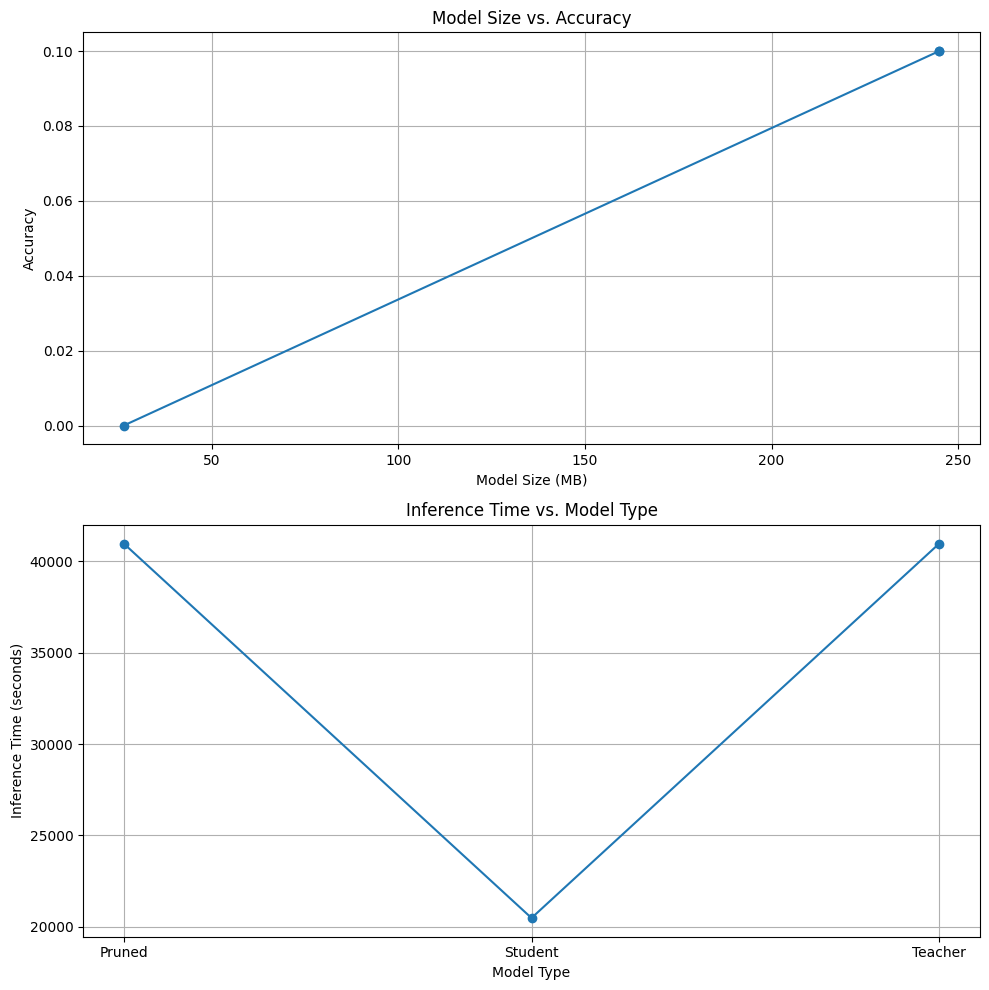

In [34]:
# Charts
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].plot([original_size, pruned_size, student_size],
         [teacher_acc, pruned_acc, student_acc], 'o-')
axs[0].set_xlabel('Model Size (MB)')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Model Size vs. Accuracy')
axs[0].grid(True)

# Inference Time vs. Model Type
axs[1].plot(["Pruned", "Student", "Teacher"],
            [pruned_time, student_time, teacher_time], 'o-')
axs[1].set_xlabel('Model Type')
axs[1].set_ylabel('Inference Time (seconds)')
axs[1].set_title('Inference Time vs. Model Type')
axs[1].grid(True)
plt.tight_layout()
plt.show()